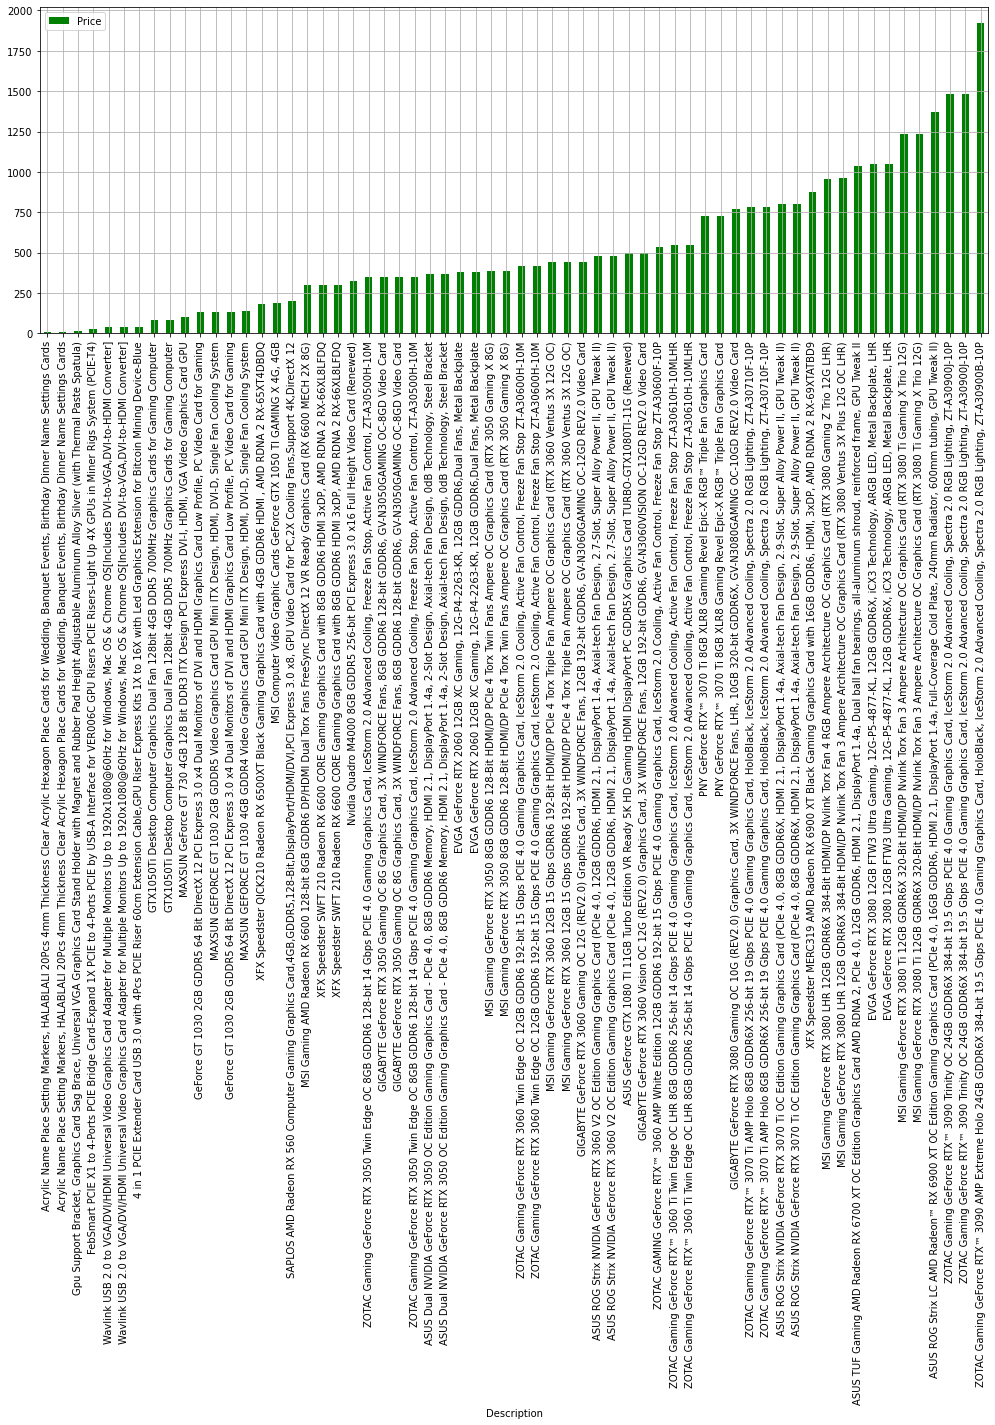

In [1]:
import csv
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import matplotlib.pyplot as plt

# Function for conversion of entered search term to Amazon default search URL address.
# Entered search term goes into curly braces of defined URL address that is stored in template variable.
# If the search term has spacing between words, space is replaced with a plus sign to be in a form of URL address.
# If the user modifies this program to search for the desired term in more than one page,
# the page variable in URL address will increment  for that number of times.


def get_url(search_term):
    template = 'https://www.amazon.com/s?k={}&crid=387QUK61IKCFW&sprefix={}%2Caps%2C196&ref=nb_sb_noss_2'
    search_term = search_term.replace(' ', '+')
    url = template.format(search_term, search_term)
    url += '&page={}'
    return url

# Function for extracting and returning data from one displayed result of a search.


def extract_record(item):

    # Getting a description from an anchor tag in item header of displayed result.
    # Getting a link to that specific tag, adding it to a URL address and storing it in a variable.
    atag = item.h2.a
    description = atag.text.strip()
    url = 'http://www.amazon.com' + atag.get('href')

    # Getting the price of a displayed result using its span classes and converting it to text format.
    # Exception handling for empty strings.
    try:
        price_parent = item.find('span', 'a-price')
        price = price_parent.find('span', 'a-offscreen').text
    except AttributeError:
        return
    # Getting the rating of a displayed result using its i tag and converting it to text format.
    # Geting the review count of a displayed results using its span classes and converting it to text format.
    try:
        rating = item.i.text
        review_count = item.find(
            'span', {'class': 'a-size-base s-underline-text'}).text
    except AttributeError:
        rating = ''
        review_count = ''

    # Storing fetched attributes in a variable and returning it.
    result = (description, price, rating, review_count, url)
    return result

# Function for starting the program's main routine. Uses both functions defined above.


def main(search_term):

    # Opening up a browser with Selenium WebDriver marionette.
    # Making the list for a records with fetched data.
    # Going through a function get_url() with entered search term.
    driver = webdriver.Firefox()
    records = []
    url = get_url(search_term)

    # Fetching the data from the first three pages of search results.
    for page in range(0, 3):

        # Formatting the URL address according to a value of page variable.
        # Parsing all search results from a web page with the division class they all have in common.
        driver.get(url.format(page))
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        results = soup.find_all(
            'div', {'data-component-type': 's-search-result'})

        # Appending the list of records with an extracted data from an item in search results.
        for item in results:
            record = extract_record(item)
            if record:
                records.append(record)

    driver.close()

    # Saving the data in .csv format with pandas library.
    # Data is stored in a results.csv file in the program's folder.
    df = pd.DataFrame(records, columns=[
                      'Description', 'Price', 'Rating', 'Number of reviews', 'URL'])
    df['Price'] = df['Price'].str.replace(',', '', regex=True).str.replace(
        '$', '', regex=True).astype('float')
    sorted_df = df.sort_values(by=["Price"], ascending=True)
    sorted_df.to_csv('results.csv', index=False, encoding='utf-8')

    # Reading the data from a pandas dataframe and dislaying it on a graph
    Description = []
    Price = []

    df2 = pd.read_csv('results.csv')
    sorted_df2 = df2.sort_values(by='Price', ascending=True)
    sorted_df2.plot(grid=True, kind='bar', x='Description',
                    y='Price', color='green', figsize=(17, 6))
    plt.xticks(rotation=90)
    plt.show()

# Desired search term
main('graphics card')